In [1]:
import scipy.io
import mat73
import numpy as np
data_dict=mat73.loadmat("D:/Supriyo/onedrive/OneDrive - iitkgp.ac.in/Sanjay_unet/vi.mat")
loc=np.load("D:/Supriyo/onedrive/OneDrive - iitkgp.ac.in/Sanjay_unet/locations.npy")
print("Data loading completed")
data=data_dict['vi']
x_temp=[]
print("segregation inti......")
for i in range(len(loc)):
    
    temp=data[:,loc[i][0]:loc[i][1]+1]
    sh=np.shape(temp)
    i,j=0,0
    while i<=sh[0] and j<=sh[1]:
        x_temp.append(temp[i:i+128,j:j+128])
        i+=128
        j+=128

Data loading completed
segregation inti......


In [5]:
np.shape(data)

(1001, 476595)

In [4]:
type(x_temp)

numpy.ndarray

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# Convert to tensors


# Create data loader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(scales=np.arange(1, 10)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pywt

# Define the activation function options
def swish(x):
    return torch.sigmoid(x) * x

class CWTLayer(nn.Module):
    def __init__(self, scales):
        super(CWTLayer, self).__init__()
        self.scales = scales

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        coeffs = []
        for i in range(batch_size):
            sample_coeffs = []
            for j in range(channels):
                channel_coeffs = pywt.cwt(x[i, j], self.scales, 'mexh')
                sample_coeffs.append(channel_coeffs)
            coeffs.append(sample_coeffs)
        coeffs = torch.stack(coeffs)
        return coeffs

class ICWTLayer(nn.Module):
    def __init__(self):
        super(ICWTLayer, self).__init__()

    def forward(self, coeffs):
        batch_size, channels, scales, height, width = coeffs.size()
        reconstructed = []
        for i in range(batch_size):
            sample_reconstructed = []
            for j in range(channels):
                channel_reconstructed = pywt.icwt(coeffs[i, j], 'mexh')
                sample_reconstructed.append(channel_reconstructed)
            reconstructed.append(sample_reconstructed)
        reconstructed = torch.stack(reconstructed)
        return reconstructed

class UNet(nn.Module):
    def __init__(self, scales):
        super(UNet, self).__init__()
        
        self.cwt = CWTLayer(scales)
        self.icwt = ICWTLayer()
        
        # Contraction path
        self.c1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.c2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.c3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.c4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.c5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Expansive path
        self.u6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.c6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.c7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.c8 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.u9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.c9 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.outputs = nn.Conv2d(16, 1, kernel_size=1)
        
    def forward(self, x):
        # Contraction path
        c1 = swish(self.c1(x))
        p1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        
        c2 = swish(self.c2(p1))
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        
        c3 = swish(self.c3(p2))
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        
        c4 = swish(self.c4(p3))
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        
        c5 = swish(self.c5(p4))
        
        # Apply CWT
        coeffs = self.cwt(c5)
        
        # Apply ICWT
        reconstructed_c5 = self.icwt(coeffs)
        
        # Expansive path
        u6 = self.u6(reconstructed_c5)
        c6 = swish(self.c6(torch.cat([u6, c4], dim=1)))
        
        u7 = self.u7(c6)
        c7 = swish(self.c7(torch.cat([u7, c3], dim=1)))
        
        u8 = self.u8(c7)
        c8 = swish(self.c8(torch.cat([u8, c2], dim=1)))
        
        u9 = self.u9(c8)
        c9 = swish(self.c9(torch.cat([u9, c1], dim=1)))
        
        outputs = self.outputs(c9)
        return outputs

alpha = 0.4
beta = 0.3
gamma = 0.3

def combined_loss(y_true, y_pred, alpha, beta, gamma):
    tv = torch.mean(torch.abs(torch.diff(y_pred, dim=2))) + torch.mean(torch.abs(torch.diff(y_pred, dim=3)))
    d2_tv = torch.mean(torch.abs(torch.diff(torch.diff(y_pred, dim=2), dim=2))) + torch.mean(torch.abs(torch.diff(torch.diff(y_pred, dim=3), dim=3)))
    mse = F.mse_loss(y_pred, y_true)
    ssim = pytorch_ssim.ssim(y_pred, y_true)

    hybrid_loss = alpha * d2_tv + beta * mse + gamma * (1 - ssim)

    return hybrid_loss

model = UNet(scales=np.arange(1, 10))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = combined_loss(targets, outputs, alpha, beta, gamma)
        loss.backward()
        optimizer.step()
        
        # Print training progress
        print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


In [3]:
x_t=[]
for i in x_temp:
    if np.shape(i)==(128,128):
        x_t.append(i)

In [4]:
np.shape(x_t)

(3312, 128, 128)

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler=MinMaxScaler()

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler=MinMaxScaler()
data=[]
for i in x_t:
    data.append(scaler.fit_transform(i))

X_train,X_test,y_train,y_test=train_test_split(data,data,test_size=0.1,random_state=42)

In [7]:
del data_dict
del loc
del data
del x_temp
del temp
del y_train
del y_test

In [14]:
#data_raw=np.load("C:/Users/gpuuser1/Desktop/sanjay/DL/method1/data.npy",allow_pickle=True)

In [16]:
#data_syn=data_raw.item()['synth_seismic_15db_noise']
#data_elas=data_raw.item()['elastic_impedance']

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.signal import fft2d, ifft2d
from tensorflow.keras.utils import plot_model
#import spconv.pytorch as spconv

In [9]:
# coarse_net()
class CustomLossLayer(tf.keras.losses.Loss):
    def __init__(self,Oc, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.Oc=Oc
    def call(self, y_true,y_pred):
        oc_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        oc_loss += tf.reduce_mean(tf.square(self.Oc - y_true))  # Replace Oc with the actual variable name if needed
        
        # Customize the loss function here, e.g., add regularization terms or additional loss components
        
        return oc_loss/2
    

def cf_net():
    # Input layer
    inputs = tf.keras.layers.Input((128, 128, 1))

    # Create a binary mask
    M = tf.keras.layers.Lambda(lambda x: tf.cast(tf.greater(x, 0), tf.float32))(inputs)
    print(type(M))

    # Create a matrix J filled with ones having the same shape as the input data
    J = tf.ones_like(inputs)
   


    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c9)

    # Add another Conv2D layer with 16 filters and softmax activation
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(c9)

    # Apply the function Oc = Gc(I) * (J - M) + I
    Oc = tf.keras.layers.Lambda(lambda x: x[0] * (x[1] - x[2]) + x[3],name="OCGC")([outputs, J, M, inputs])

    # Upsampling and padding in the Fourier domain
    #F_oc = tf.keras.layers.Lambda(lambda x: tf.signal.fft2d(tf.cast(x, tf.complex64)))(Oc)
    #F_oc_padded = tf.keras.layers.Lambda(lambda x: tf.pad(x, [[32, 32], [32, 32], [32, 32], [32, 32]], mode='CONSTANT'),name="OC_PADDED")(F_oc)
    #I_u = tf.keras.layers.Lambda(lambda x: tf.signal.ifft2d(tf.cast(x, tf.complex64)))(F_oc_padded)
    

    # Fine_net

    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same',name="fine_net_start")(abs(Oc))
    c1 = tf.keras.layers.Dropout(0.2)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    f1 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p1)
    f1 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(abs(f1))
    c2 = tf.keras.layers.Dropout(0.3)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    f2 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p2)
    f2 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.gelu, kernel_initializer='he_normal', padding='same')(abs(f2))
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.gelu, kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    f3 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p3)
    f3 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(abs(f3))
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    f4 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p4)
    f4 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(abs(f4))
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    f6 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(c6)
    f6 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(abs(f6))
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    f7 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(c7)
    f7 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(abs(f7))
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.3)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    f8 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(c8)
    f8 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(abs(f8))
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(c9)

    # Add another Conv2D layer with 16 filters and softmax activation
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='softmax')(c9)

   # Loss to train 
    def mse_loss(y_true, y_pred):
        of_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        oc_loss = tf.reduce_mean(tf.square(Oc - y_true))
        return (of_loss+oc_loss)/2

    def fourier_loss(y_true, y_pred):
        return tf.reduce_mean(tf.abs(tf.signal.fft2d(tf.cast(y_pred, tf.complex64)) - tf.signal.fft2d(tf.cast(y_true, tf.complex64))))

    # Define the total loss as a weighted sum of the mse and Fourier losses
    #def total_loss(y_true, y_pred, alpha=0.5):
       # return mse_loss(y_true, y_pred) + alpha * fourier_loss(y_true, y_pred)

    # Create the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    loss_layer = CustomLossLayer(Oc)

    # Call the loss layer with appropriate inputs
    #total_loss = loss_layer([y_true, y_pred, Oc])
    # Compile the model
    model.compile(optimizer='adam', loss=loss_layer)
    
    return model

# Create the model
model = cf_net()

# Print model summary
model.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )             

: 

: 

In [ ]:
history=model.fit(tf.expand_dims(X_train, axis=-1),tf.expand_dims(X_train, axis=-1), epochs = 100)

Epoch 1/100
94/94 [==============================] - 719s 8s/step - loss: 3.3783
Epoch 2/100
94/94 [==============================] - 704s 7s/step - loss: 1.0795
Epoch 3/100
94/94 [==============================] - 709s 8s/step - loss: 0.3963
Epoch 4/100
94/94 [==============================] - 715s 8s/step - loss: 0.3096
Epoch 5/100
94/94 [==============================] - 698s 7s/step - loss: 0.3092
Epoch 6/100
94/94 [==============================] - 695s 7s/step - loss: 0.3092
Epoch 7/100
94/94 [==============================] - 698s 7s/step - loss: 0.3092
Epoch 8/100
94/94 [==============================] - 691s 7s/step - loss: 0.3092
Epoch 9/100
94/94 [==============================] - 688s 7s/step - loss: 0.3091
Epoch 10/100
94/94 [==============================] - 690s 7s/step - loss: 0.3091
Epoch 11/100
94/94 [==============================] - 691s 7s/step - loss: 0.3091
Epoch 12/100
94/94 [==============================] - 691s 7s/step - loss: 0.3091
Epoch 13/100
94/94 [=====

: 

: 

In [ ]:
# Save the model
model.save('my_model.h5')

In [5]:
# coarse_net()
def gelu(x):
    cdf = 0.5 * (1.0 + tf.tanh((np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

def coarse_net():
    # Input layer
    inputs = tf.keras.layers.Input((128, 128, 1))

    # Create a binary mask
    M = tf.keras.layers.Lambda(lambda x: tf.cast(tf.greater(x, 0), tf.float32))(inputs)

    # Create a matrix J filled with ones having the same shape as the input data
    J = tf.ones_like(inputs)
   


    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c9)

    # Add another Conv2D layer with 16 filters and softmax activation
    outputs = tf.keras.layers.Conv2D(16, (1, 1), activation='softmax')(c9)

    # Apply the function Oc = Gc(I) * (J - M) + I
    Oc = tf.keras.layers.Lambda(lambda x: x[0] * (x[1] - x[2]) + x[3])([outputs, J, M, inputs])

    # Create the model
    model = tf.keras.Model(inputs=[inputs], outputs=[Oc])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

# Create the model
model = coarse_net()

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [7]:
# fine_unet
def fine_unet():
    inputs = tf.keras.layers.Input((128, 128, 1))

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.2)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    f1 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p1)
    f1 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(abs(f1))
    c2 = tf.keras.layers.Dropout(0.3)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    f2 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p2)
    f2 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.gelu, kernel_initializer='he_normal', padding='same')(abs(f2))
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.gelu, kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    f3 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p3)
    f3 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(abs(f3))
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    f4 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(p4)
    f4 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(abs(f4))
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    f6 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(c6)
    f6 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(abs(f6))
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    f7 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(c7)
    f7 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(abs(f7))
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.3)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    f8 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v, tf.complex64)))(c8)
    f8 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v, tf.complex64)))(f8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(abs(f8))
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(c9)

    # Add another Conv2D layer with 16 filters and softmax activation
    outputs = tf.keras.layers.Conv2D(16, (1, 1), activation='softmax')(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    def mse_loss(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    def fourier_loss(y_true, y_pred):
        return tf.reduce_mean(tf.abs(tf.signal.fft2d(tf.cast(y_pred, tf.complex64)) - tf.signal.fft2d(tf.cast(y_true, tf.complex64))))

    # Define the total loss as a weighted sum of the mse and Fourier losses
    def total_loss(y_true, y_pred, alpha=0.5):
        return mse_loss(y_true, y_pred) + alpha * fourier_loss(y_true, y_pred)

    # Compile the model
    model.compile(optimizer='adam', loss=total_loss)

    return model
# Create the model
model = fine_unet()
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_97 (Conv2D)             (None, 128, 128, 16  160         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_45 (Dropout)           (None, 128, 128, 16  0           ['conv2d_97[0][0]']              
                                )                                                           

In [11]:
coarse_unet = coarse_net()
fine_unet = fine_net()
inputs = tf.keras.layers.Input((128, 128, 1))

# Feed the input into the coarse U-Net
coarse_output = coarse_unet(inputs)

# Upsample the output from the coarse U-Net
coarse_output_fft = fft2d(tf.cast(coarse_output, tf.complex64))
padded_coarse_output_fft = tf.pad(coarse_output_fft, [[0,0], [0,Ni//2], [0,Nj//2], [0,0]])  # Add zero-padding
upsampled_output = ifft2d(padded_coarse_output_fft)

# Feed the upsampled output into the fine U-Net
fine_output = fine_unet(upsampled_output)

# The combined model
combined_model = tf.keras.Model(inputs=[inputs], outputs=[fine_output])

def cfunet_loss(y_true, y_pred):
    # This is the loss function you specified, with L assumed to be y_true
    return tf.reduce_mean(tf.square(coarse_output - y_true)) + tf.reduce_mean(tf.square(fine_output - y_true))

combined_model.compile(optimizer='adam', loss=cfunet_loss)


NameError: name 'coarse_unet' is not defined

In [12]:
inputs = tf.keras.layers.Input((128,128,1))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
f1 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v,tf.complex64)))(p1)
f1 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v,tf.complex64)))(f1)
print(p1.shape)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(abs(f1))
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
f2 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v,tf.complex64)))(p2)
f2 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v,tf.complex64)))(f2)
print(p2.shape)


c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(abs(f2))
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
f3 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v,tf.complex64)))(p3)
f3 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v,tf.complex64)))(f3)
print(p3.shape)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(abs(f3))
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
f4 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v,tf.complex64)))(p4)f4 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v,tf.complex64)))(f4)
print(p4.shape)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(abs(f4))
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c5)
print(c5.shape)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
print(u6.shape)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
f6 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v,tf.complex64)))(c6)
f6 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v,tf.complex64)))(f6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(abs(f6))
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
f7 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v,tf.complex64)))(c7)
f7 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v,tf.complex64)))(f7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(abs(f7))
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
f8 = tf.keras.layers.Lambda(lambda v: tf.signal.fft2d(tf.cast(v,tf.complex64)))(c8)
f8 = tf.keras.layers.Lambda(lambda v: tf.signal.ifft2d(tf.cast(v,tf.complex64)))(f8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(abs(f8))
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

(None, 64, 64, 16)
(None, 32, 32, 32)
(None, 16, 16, 64)
(None, 8, 8, 128)
(None, 8, 8, 256)
(None, 16, 16, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]'

                                                                                                  
 lambda_8 (Lambda)              (None, 16, 16, 128)  0           ['conv2d_11[0][0]']              
                                                                                                  
 lambda_9 (Lambda)              (None, 16, 16, 128)  0           ['lambda_8[0][0]']               
                                                                                                  
 tf.math.abs_4 (TFOpLambda)     (None, 16, 16, 128)  0           ['lambda_9[0][0]']               
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 32, 32, 64)  32832       ['tf.math.abs_4[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatena

In [14]:
history=model.fit(tf.expand_dims(X_train, axis=-1),tf.expand_dims(X_train, axis=-1), epochs = 100)

Epoch 1/100
94/94 [==============================] - 777s 8s/step - loss: 0.0128 - accuracy: 0.0163
Epoch 2/100
94/94 [==============================] - 818s 9s/step - loss: 0.0022 - accuracy: 0.0169
Epoch 3/100
94/94 [==============================] - 82825s 890s/step - loss: 0.0014 - accuracy: 0.0169
Epoch 4/100
94/94 [==============================] - 422s 4s/step - loss: 0.0011 - accuracy: 0.0169
Epoch 5/100
94/94 [==============================] - 554s 6s/step - loss: 8.6423e-04 - accuracy: 0.0169
Epoch 6/100
94/94 [==============================] - 450s 5s/step - loss: 7.3850e-04 - accuracy: 0.0169
Epoch 7/100
94/94 [==============================] - 452s 5s/step - loss: 6.4614e-04 - accuracy: 0.0169
Epoch 8/100
94/94 [==============================] - 449s 5s/step - loss: 5.7806e-04 - accuracy: 0.0169
Epoch 9/100
94/94 [==============================] - 449s 5s/step - loss: 5.2420e-04 - accuracy: 0.0169
Epoch 10/100
94/94 [==============================] - 450s 5s/step - loss: 4

In [15]:
model.save('Unet_fft_fft.h5')

In [4]:
model=tf.keras.models.load_model('Unet_fft_fft.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 lambda_8 (Lambda)              (None, 16, 16, 128)  0           ['conv2d_11[0][0]']              
                                                                                                  
 lambda_9 (Lambda)              (None, 16, 16, 128)  0           ['lambda_8[0][0]']               
                                                                                                  
 tf.math.abs_4 (TFOpLambda)     (None, 16, 16, 128)  0           ['lambda_9[0][0]']               
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 32, 32, 64)  32832       ['tf.math.abs_4[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_1 (Concatenate)    (None, 32, 32, 128)  0           ['conv2d_transpose_1[0][0]',     
          

In [2]:
# Coarse Unet for seismic Inversion
import tensorflow as tf

# Input layer
inputs = tf.keras.layers.Input((128,128,1))

# Create a binary mask
M = tf.keras.layers.Lambda(lambda x: tf.cast(tf.greater(x, 0), tf.float32))(inputs)

# Create a matrix J filled with ones having the same shape as the input data
J = tf.ones_like(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='gelu', kernel_initializer='he_normal', padding='same')(c9)

# Add another Conv2D layer with 16 filters and softmax activation
outputs = tf.keras.layers.Conv2D(16, (1, 1), activation='softmax')(c9)

# Apply the function Oc = Gc(I) * (J - M) + I
Oc = tf.keras.layers.Lambda(lambda x: x[0] * (x[1] - x[2]) + x[3])([outputs, J, M, inputs])

# Create the model
model = tf.keras.Model(inputs=[inputs], outputs=[Oc])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [5]:
a=np.zeros(np.shape(temp))

In [6]:
np.shape(a),np.shape(temp)

((1001, 810), (1001, 810))

In [ ]:
i,j=0,0
pred=[]
sh=np.shape(temp)
while i<=sh[0]:
    j=0
    while j<=sh[1]:
        if np.shape(temp[i:i+128,j:j+128])==(128,128):
            #pred.append(temp[i:i+128,j:j+128])
            temppp=model.predict(tf.expand_dims(np.reshape(scaler.fit_transform(temp[i:i+128,j:j+128]),(1,128,128)), axis=-1))
            temppp=np.reshape(temppp,(128,128))
            a[i:i+128,j:j+128]=temppp.copy()
        j+=128
    i+=128

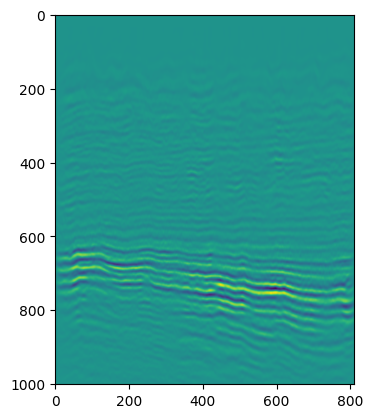

In [12]:
plt.imshow(temp)

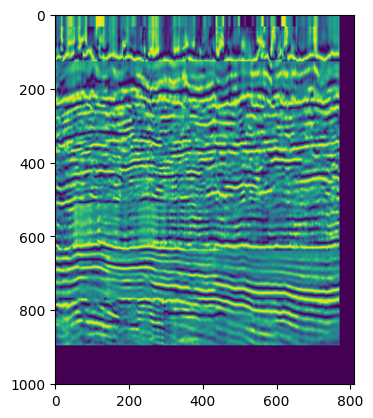

In [13]:
plt.imshow(a)

In [ ]:
test=[]
for i in pred:
    test.append(scaler.fit_transform(i))
predd=model.predict(tf.expand_dims(np.array(test[20]), axis=-1))

In [1]:
# Unet fft changes to cwt


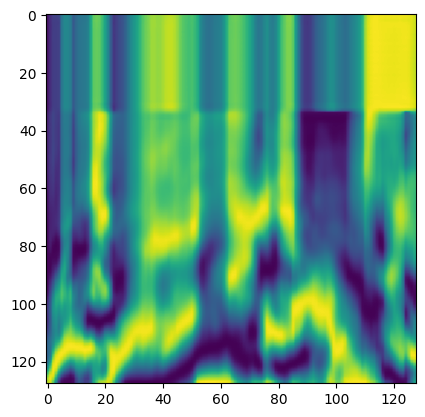

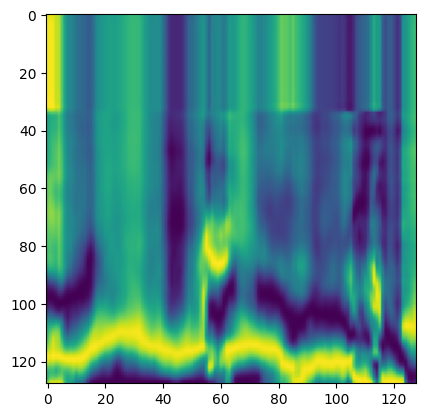

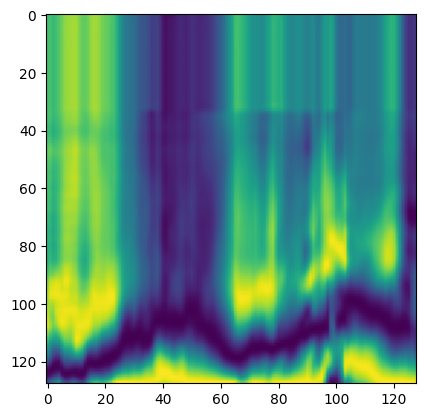

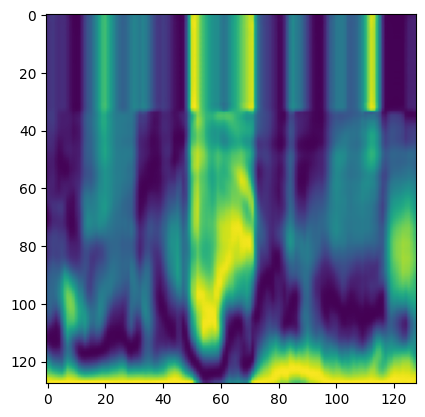

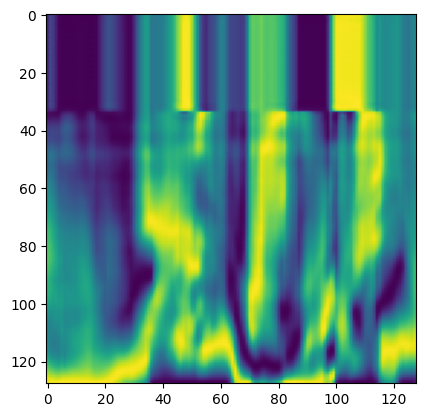

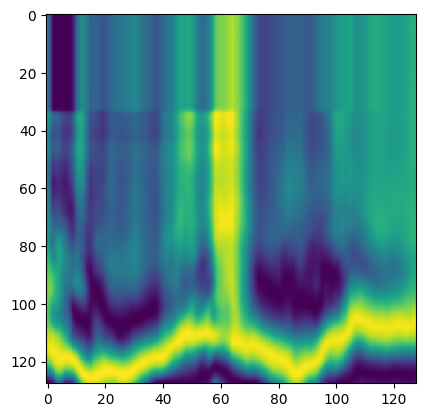

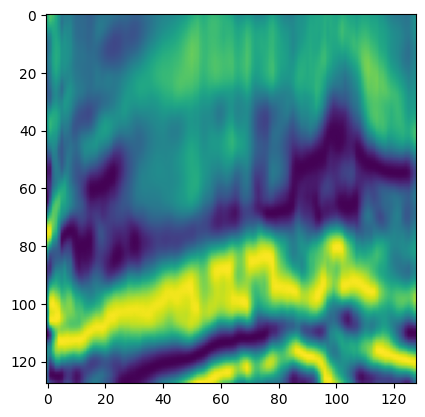

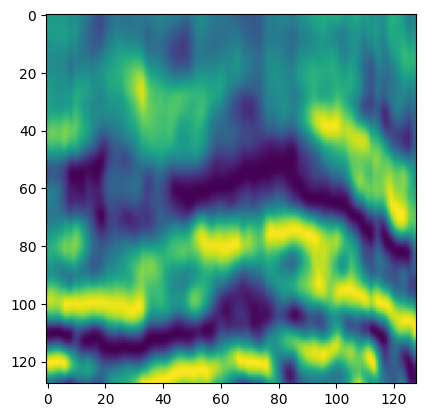

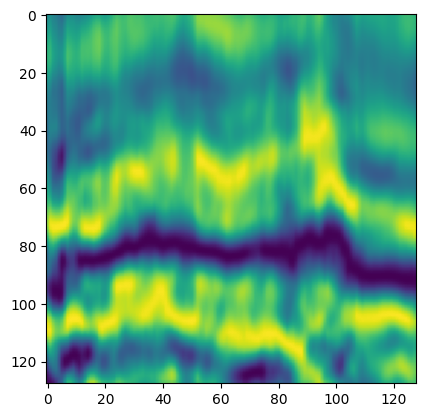

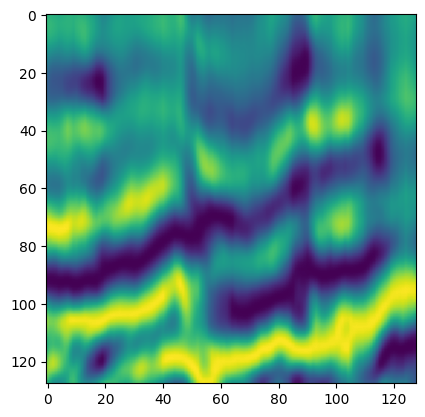

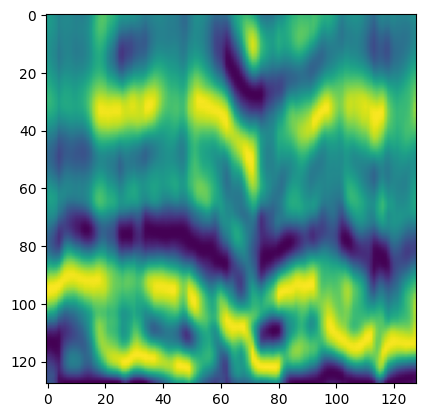

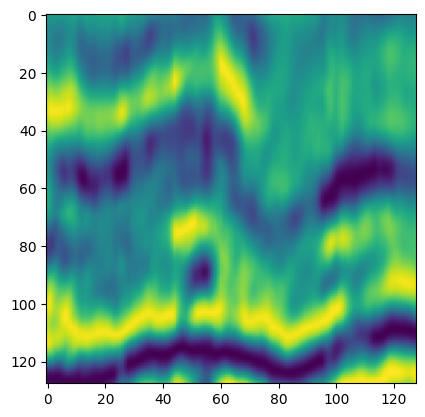

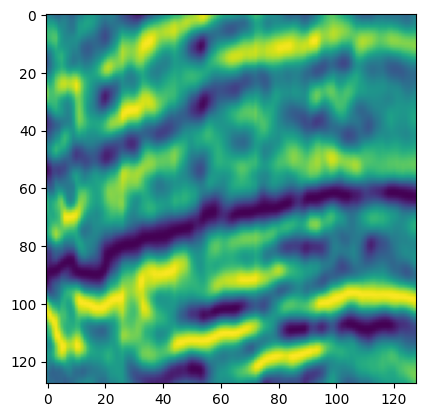

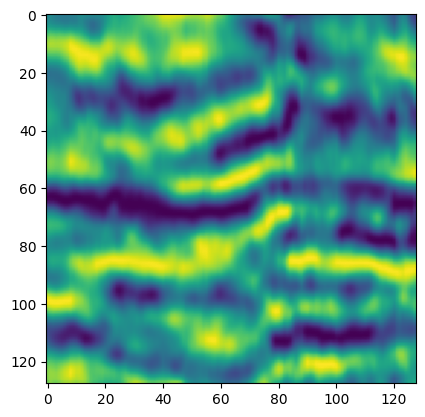

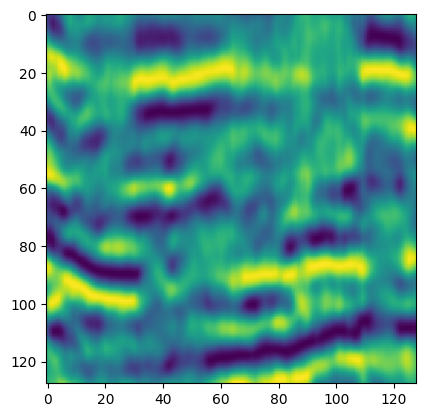

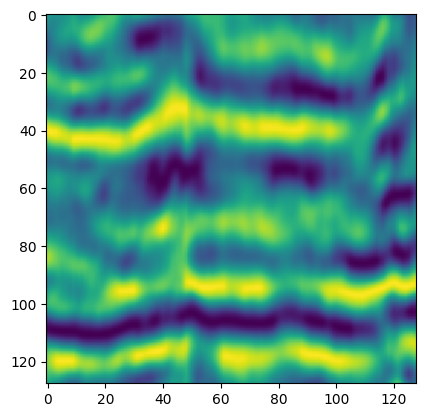

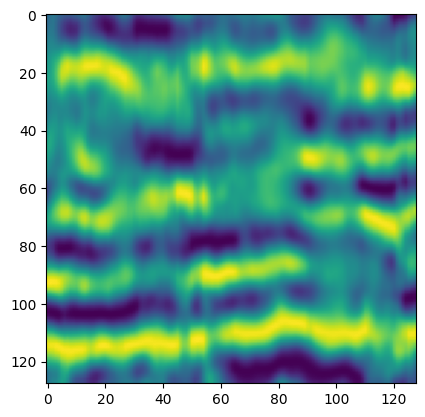

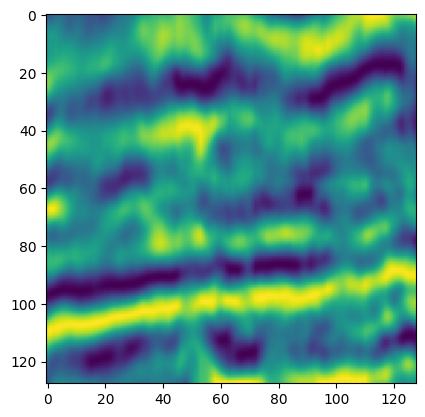

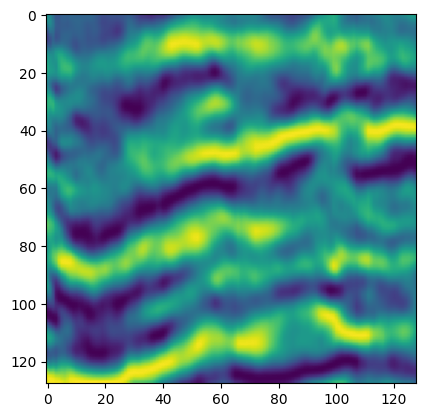

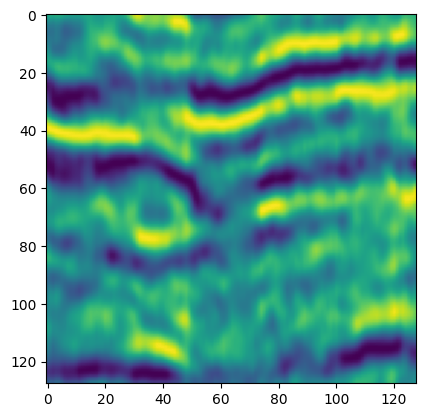

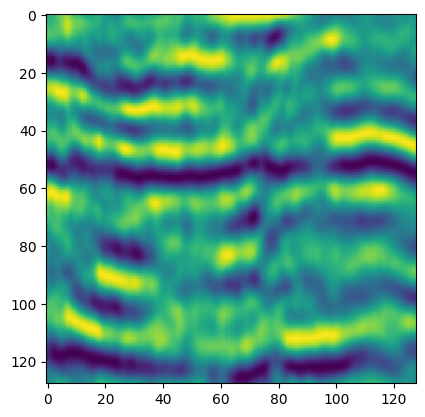

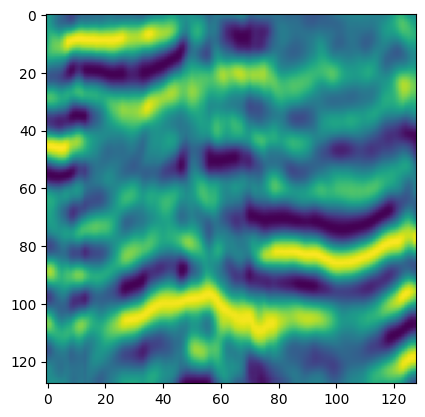

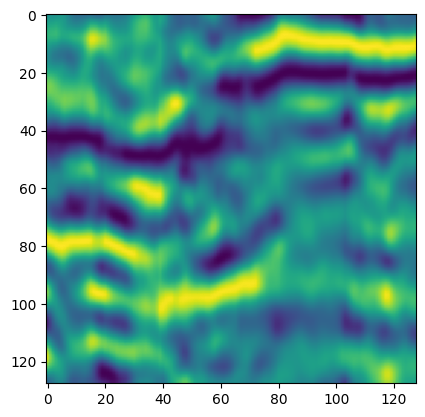

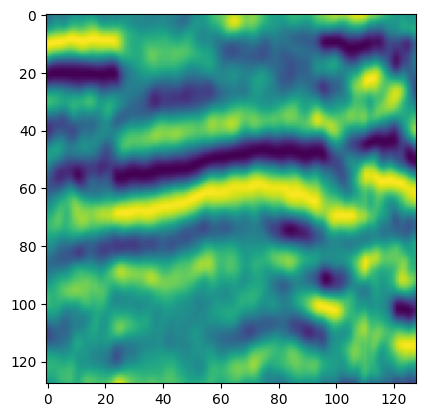

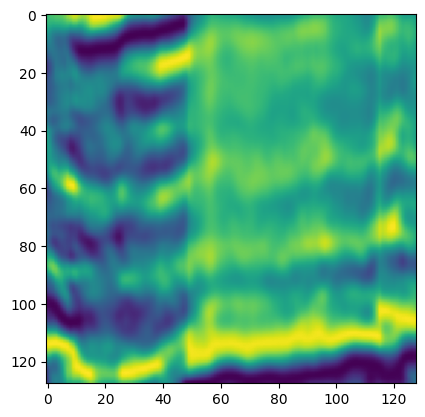

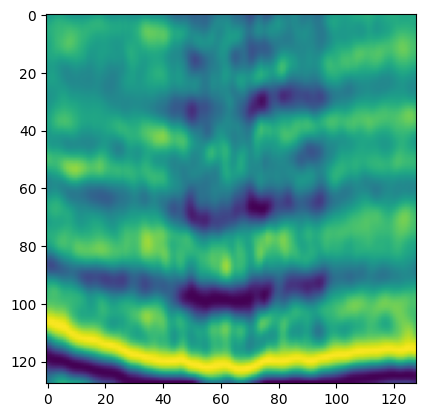

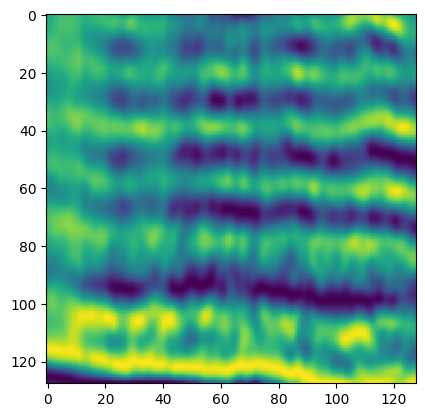

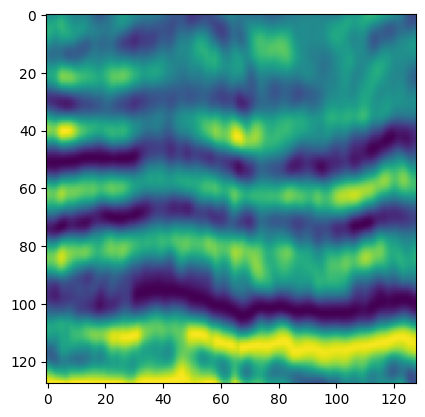

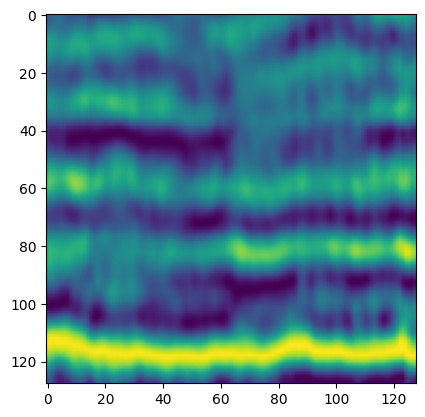

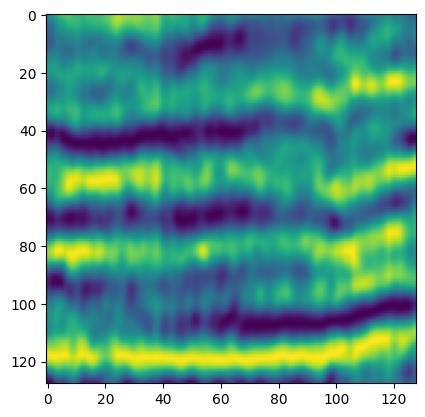

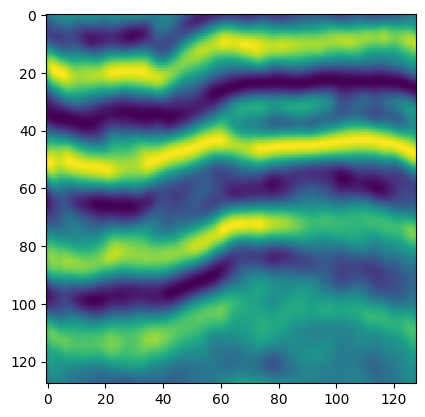

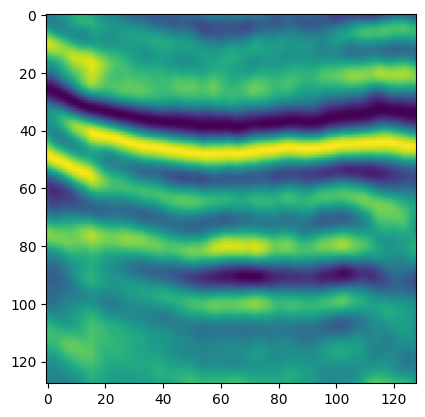

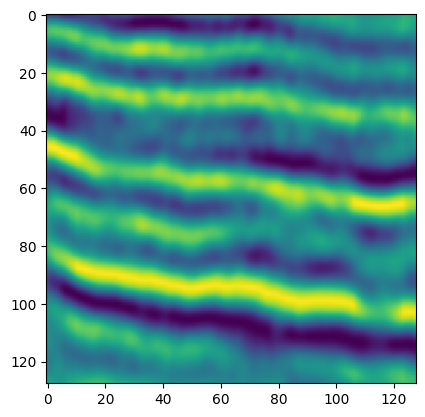

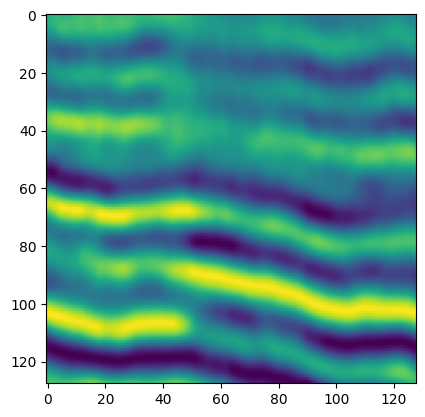

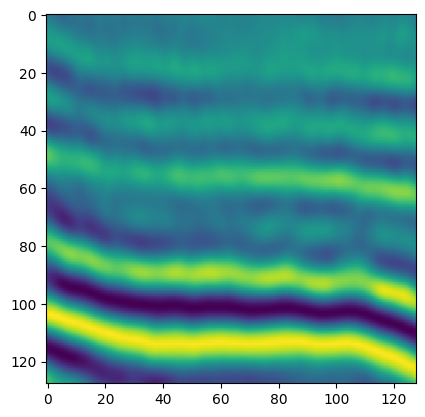

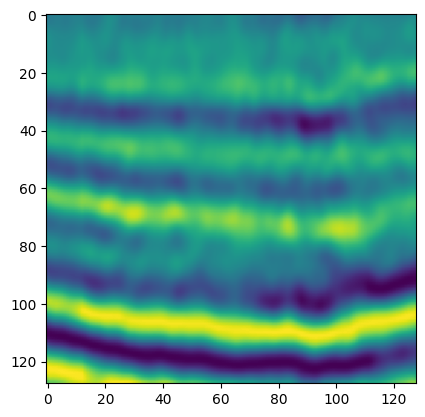

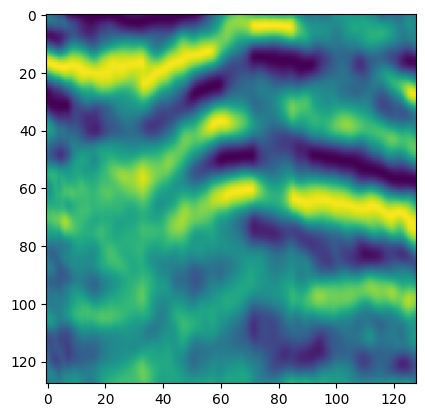

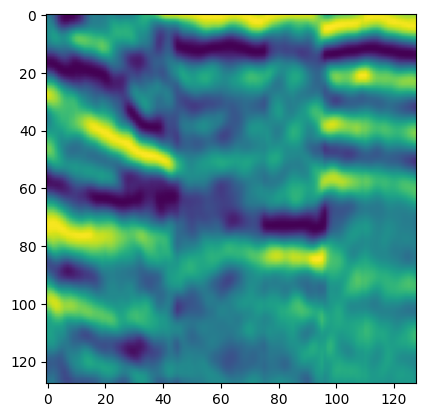

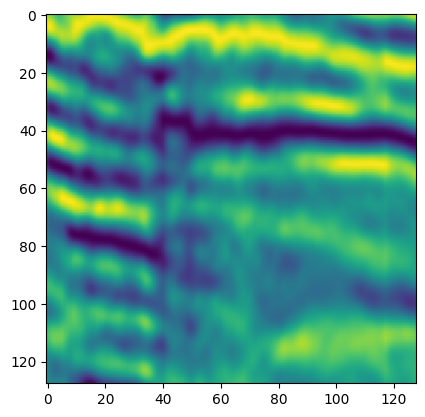

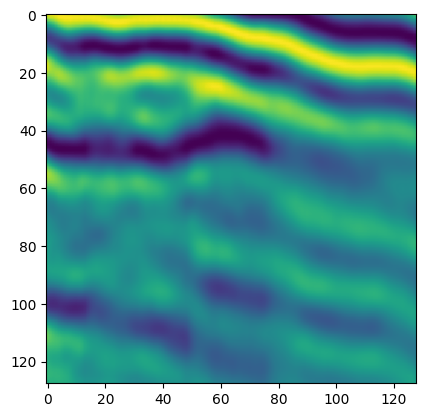

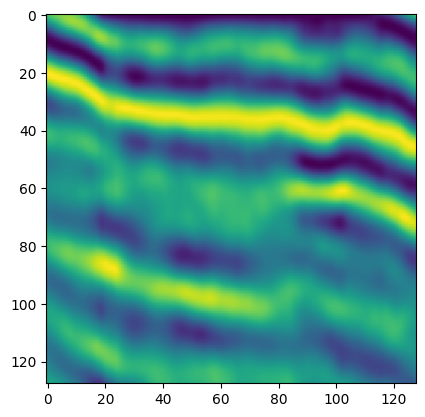

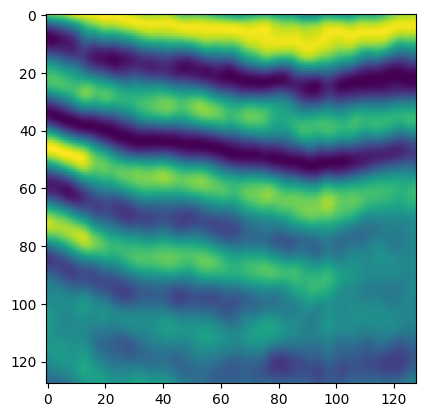

In [41]:
for i in predd:
    plt.imshow(i)
    plt.show()

In [43]:
ori_test=[]
(1001, 810)
for i in test:
    if x<810:
        ori_test=np.concatenate(ori_test,i)
    

TypeError: array() missing required argument 'object' (pos 0)

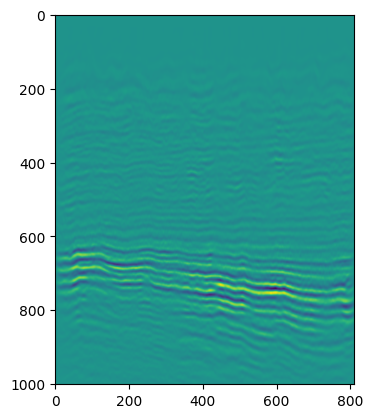

In [46]:
plt.imshow(temp)

In [51]:
a=scaler.inverse_transform(marrr[0])[:151, :461]
b=scaler.inverse_transform(np.reshape(pred[0],(512,512)))[:151, :461]

In [52]:
np.shape(a)

(151, 461)

In [53]:
scipy.io.savemat('Unet_fft_mar1_ori.mat', {'Unet_fft_mar1_ori':a })
scipy.io.savemat('Unet_fft_mar1_pred.mat', {'Unet_fft_mar1_pred': b})

In [16]:
model.save('Unet_fft.h5')

In [2]:
model=tf.keras.models.load_model('Unet_fft_2.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_9 (Conv2D)              (None, 32, 32, 256)  590080      ['dropout_4[0][0]']              
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 128)  131200     ['conv2d_9[0][0]']               
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 256)  0           ['conv2d_transpose[0][0]',       
                                                                  'conv2d_7[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 128)  295040      ['concatenate[0][0]']            
                                                                                                  
 dropout_5

 conv2d_18 (Conv2D)             (None, 512, 512, 1)  17          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 1,940,817
Trainable params: 1,940,817
Non-trainable params: 0
__________________________________________________________________________________________________


In [4]:
import scipy
B=scipy.io.loadmat("D:/New folder/CPSO/B.mat")['arr']

In [16]:
np.shape(b[:512,:])

(512, 512)

In [14]:
b=np.concatenate((B,np.zeros((580,12))),axis=-1)

In [18]:
pred=model.predict(tf.expand_dims(np.reshape(b[:512,:],(1,512,512)), axis=-1))

1/1 [==============================] - 4s 4s/step


In [27]:
scipy.io.savemat('Unet_fft_sys_pred.mat', {'Unet_fft_sys_pred': pred[0].T[0].T})

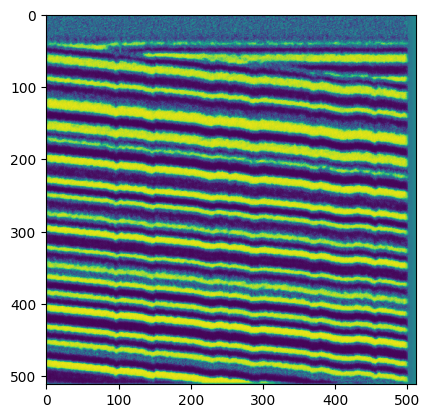

In [26]:
plt.imshow(pred[0].T[0].T)

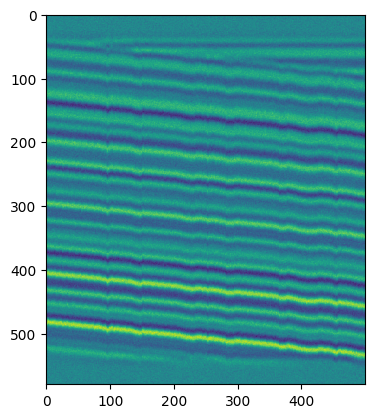

In [28]:
plt.imshow(B)

In [29]:
from frechetdist import frdist

In [30]:
frdist(b[:512,:],pred[0].T[0].T)

93.94474876016534

In [32]:
import math

In [33]:
MSE = np.square(np.subtract(b[:512,:],pred[0].T[0].T)).mean()  
math.sqrt(MSE)

2.7113914127789944

In [1]:
import scipy
import numpy as np
a=np.load("C:/Users/hp/Desktop/RC_synthetic.npy")
scipy.io.savemat("rc.mat",{"rc":a})